In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
dataset_path = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"

In [4]:
BATCH_SIZE = 32

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [6]:
#LOAD DATASET
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [7]:
#CHECK CLASS DISTRIBUTION
class_names = dataset.class_names
class_counts = Counter()
for _,labels in dataset.unbatch():
    class_counts[int(labels.numpy())] +=1
print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")

Class Distribution:
AB-: 761
B+: 652
O+: 852
A-: 1009
AB+: 708
A+: 565
O-: 712
B-: 741


In [9]:
import matplotlib.pyplot as plt
def plot_class_distribution(class_names, class_counts):
    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]
    plt.figure(figsize=(10,6))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Blood Groups')
    plt.ylabel('Number of Images')
    plt.title('Dataset Class Distribution')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, str(yval), ha='center', va='bottom')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

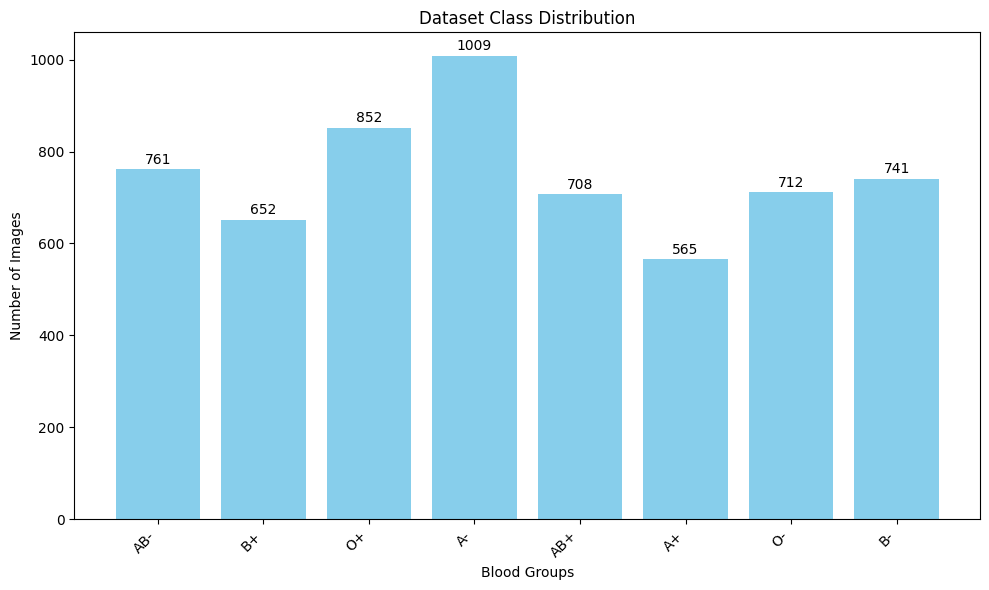

In [10]:
plot_class_distribution(class_names, class_counts)

In [11]:
max_count = max(class_counts.values())

In [12]:
#Function to oversample a class
def oversample_class(class_id, count, max_count):
    #Ensure the dataset is unbatched for filtering
    unbatched_dataset = dataset.unbatch()

    #Filter the dataset for the specific class
    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

    #calculate the number of repetitions needed
    repeat_factor = max_count // count + (max_count % count > 0)

    #repeat the dataset to match the desired count
    return class_dataset.repeat(repeat_factor).take(max_count)

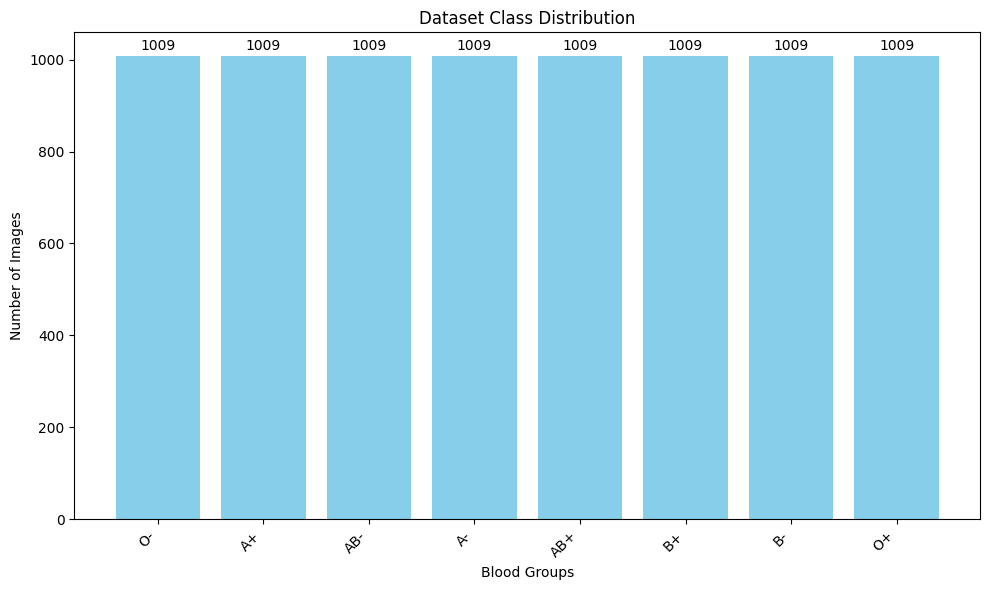

In [13]:
#balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))

#combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

#check balanced class distribution
balanced_class_counts = Counter([int(lb1.numpy()) for _, lb1 in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

#batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [15]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [18]:
# Define constants for the dataset split
total_samples = 8032  # The total dataset size (adjust according to your data)
train_size = 5632     # Desired size for training dataset
val_size = 1600       # Desired size for validation dataset
test_size = 800       # Desired size for testing dataset

# Unbatch the dataset to work at the sample level
balanced_dataset_unbothered = balanced_dataset.unbatch()

# Split the dataset into training, validation, and test datasets
train_dataset = balanced_dataset_unbothered.take(train_size)
val_test_dataset = balanced_dataset_unbothered.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
BATCH_SIZE = 32  # Example batch size, adjust as needed
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

# Output the total number of samples and batches for each dataset
print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")


Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 832


In [20]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),  # Explicit Input layer

        tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Create the model
high_acc_model = create_high_accuracy_model()


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


In [22]:
#Train the model
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
    176/Unknown 53s 286ms/step - accuracy: 0.1250 - loss: 37.5786

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 378ms/step - accuracy: 0.1250 - loss: 37.4217 - val_accuracy: 0.1170 - val_loss: 2.0398 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 374ms/step - accuracy: 0.1417 - loss: 2.0750 - val_accuracy: 0.1189 - val_loss: 2.0459 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 372ms/step - accuracy: 0.3051 - loss: 1.8089 - val_accuracy: 0.1170 - val_loss: 2.0970 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.3603 - loss: 1.6565
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 372ms/step - accuracy: 0.3603 - loss: 1.6564 - val_accuracy: 0.1630 - val_loss: 2.1449 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 374ms/step - accuracy: 0.4055 - loss: 1.5601 - val_accuracy: 0.2739 - val_loss: 1.8871 - learning_rate: 5.0000e-04
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 373ms/step - accuracy: 0.4778 - lo

In [23]:
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8553 - loss: 0.4846
High Accuracy Model - Loss: 0.4741862714290619, Accuracy: 0.8351715803146362


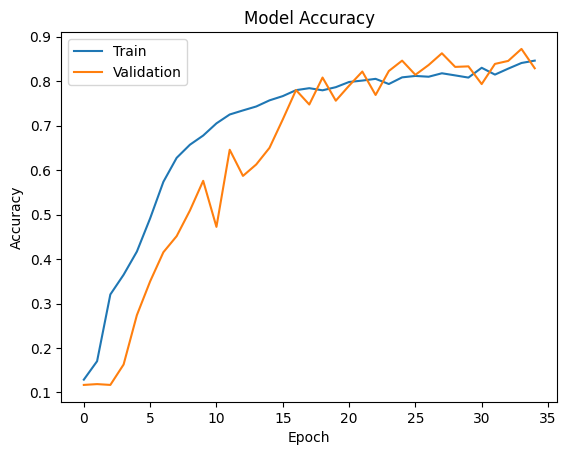

In [24]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Classificat

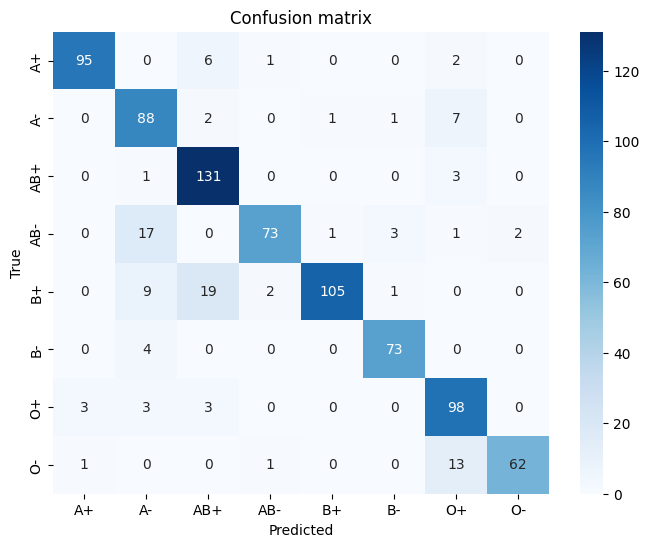

In [25]:
y_true = []
y_pred = []
for images, labels in test_dataset:
    predictions = high_acc_model.predict(images)
    predicted_labels = np.argmax(predictions, axis = 1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true,y_pred,target_names=class_names)
print("Classification Report:")
print(report)


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format.")

Model saved as HDF5 format.
